# Exploration 08 : 뉴스 요약봇 만들기

## 학습 목표
- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

In [ ]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
31562,Video shows Nita Ambani chanting mantras durin...,A video of Mumbai Indians' owner Nita Ambani p...
52309,Who are the past winners of the reality show B...,The first edition of reality show 'Bigg Boss' ...
63476,Mallika's dad calls Twinkle 'embarrassed wife'...,Comedian Mallika Dua's father Vinod Dua slamme...
38732,Ivanka Trump tweets a 'Chinese proverb' that d...,US President Donald Trump's daughter Ivanka Tr...
55996,Why is Priyanka's fee of Ã¢ÂÂ¹5cr for show sh...,While reacting to reports of actress Priyanka ...
24841,4-time world champ Hamilton wins F1 race after...,Four-time world champion Lewis Hamilton won th...
60550,"Kerala, Kolkata play out goalless draw in ISL ...",Defending champions ATK and last edition's run...
2653,K'taka auto driver killed by another driver fo...,Karnataka's 67-year-old autorickshaw driver Na...
83100,Volvo self-driving cars 'confused' by kangaroo...,Swedish carmaker Volvo has said its self-drivi...
96704,"30 blasts occur at ordnance factory in MP, 20...",At least 20 people were reportedly injured aft...


In [ ]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
print(data.shape)

(98401, 2)


In [ ]:
data = data[['headlines','text']]
data.head()

# 랜덤한 15개 샘플 출력
data.sample(15)

,headlines,text
53207,BJP candidate made to wear garland of shoes du...,BJP candidate Dinesh Sharma was made to wear a...
69378,Senior mahant of body which made fake baba lis...,Mahant Mohan Das of Akhil Bharatiya Akhara Par...
92297,Man wins women's lingerie photo contest,"A 20-year-old man from Russia, Andrew Nagorny,..."
91205,"Surgeon plans reviving frozen brain, 1st trans...",Italian doctor Sergio Canavero famed for his p...
70680,Excise inspector shot at outside his office in...,A 31-year-old excise inspector was shot in his...
37566,Taliban kills 30 Afghan soldiers after Eid cea...,The Taliban on Wednesday killed 30 Afghan sold...
75713,"Sun Pharma, 10 others pay Ã¢ÂÂ¹18 lakh for in...","Sun Pharmaceutical, its Founder Dilip Shanghvi..."
49606,Word 'reform' used and abused many times: Manm...,"Commenting on the 2018 Budget, former Prime Mi..."
27732,Federer wore pants backwards before lifting Wi...,Talking about his career's most embarrassing m...
10902,More than 200 mass graves discovered in Iraq: ...,Over 200 graves containing the corpses of thou...


## 데이터 전처리 (정리하기)

- 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [ ]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [ ]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
# Null값 남아있는지 확인하기
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 텍스트 정규화와 불용어 제거

- 같은 의미를 지닌 다른 단어들을 제거 (연산량을 줄여주기 위해)
- ex) it will & it'll, mustn't & must not

In [ ]:
# 텍스트 정규화를 위한 사전 구성

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

#### 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어주는 함수를 호출해보자

In [ ]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [ ]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [ ]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

<ipython-input-11-165776f0a558>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [ ]:
# 보다 쉽게 확인하기 위해 데이터를 데이터프레임에 재저장
# 빈(empty)값을 가진 샘플들은 전부 Null 값으로 대처
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [ ]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 데이터 전처리: train데이터와 test데이터로 나누기

- 샘플의 최대 길이 정하기
- text와 headlines의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화해서 보기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


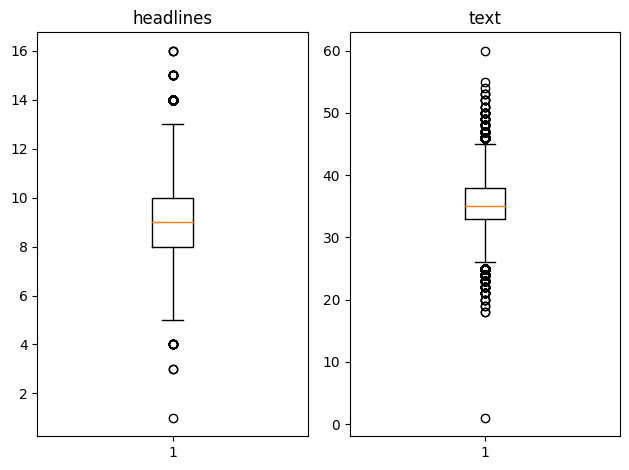

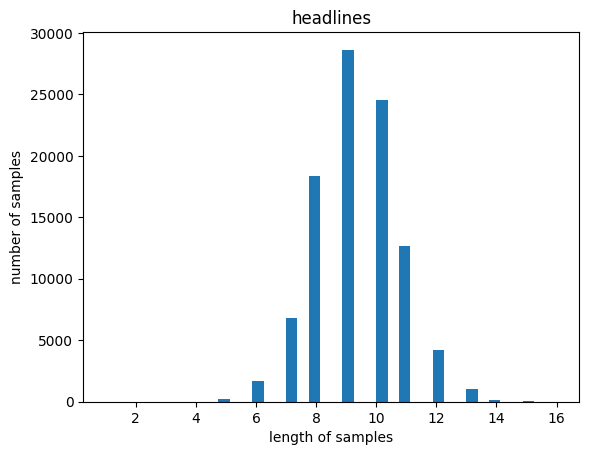

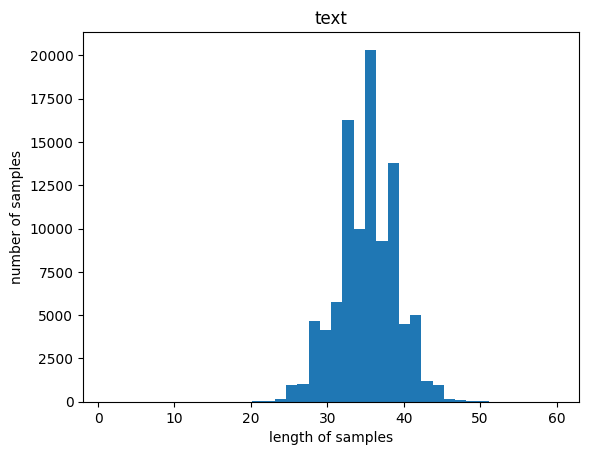

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있다

- text의 경우 최소 길이가 2, 최대 길이가 1,235로 그 차이가 굉장히 크다. 하지만 평균 길이는 38로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있다

- headlines의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧다

- 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있다

In [ ]:
# text, headlines의 최대길이와 적절한 최대 길이를 임의로 정해보기

text_max_len = 45
headlines_max_len = 13

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [ ]:
# row들을 뽑아서 headlines_max_len과 비교시킨다
# headlines_max_len 보다 길이가 적으면 필터가 된다
# headlines_max_len 보다 길이가 길면 false가 리턴된다

# pandas .apply 함수
# axis를 정해 해당 행, 열 마다 특정 함수를 적용시킨다

data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 98180


## 시작 토큰과 종료 토큰 추가하기
----------------------------
- 시작 토큰을 sostoken
- 종료 토큰은 eostoken

- 디코더 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target

In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

<ipython-input-22-5f0b0a3a6e34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
<ipython-input-22-5f0b0a3a6e34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [ ]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## train 데이터와 test 데이터 분리하기

In [ ]:
## encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[67354 39630  7984 ... 14243 68791  5503]


In [ ]:
# 위의 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 됨
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리하기 위해 테스트 데이터의 크기 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19636


In [ ]:
# 정의한 테스트 데이터의 개수 이용해서 전체 데이터 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78544
훈련 레이블의 개수 : 78544
테스트 데이터의 개수 : 19636
테스트 레이블의 개수 : 19636


## 데이터 전처리: 정수 인코딩
-----------------
단어 집합 만들기 및 정수 인코딩

- 이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하고 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요.

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.

빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하겠다
src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69572
등장 빈도가 6번 이하인 희귀 단어의 수: 47431
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22141
단어 집합에서 희귀 단어의 비율: 68.1754153969988
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.490321127389975


In [ ]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4690, 2409, 4690, 7662, 15361, 12535, 1149, 14789, 9306, 86, 3626, 717, 568, 1745, 1847, 4276, 6178, 1, 883, 15990, 10066, 7080, 6326, 56, 4690, 376, 4276, 12535, 31, 1647, 1736, 508, 29, 3], [21, 695, 345, 834, 1471, 334, 9133, 5526, 2255, 157, 531, 89, 1017, 1371, 399, 369, 457, 4237, 351, 345, 359, 15, 6179, 6879, 99, 3241, 167, 334, 359, 228, 428, 1017, 1371, 399, 354, 4237, 1330, 1, 993, 8408], [27, 78, 1173, 914, 58, 1, 8004, 4036, 55, 671, 49, 114, 48, 2889, 13361, 914, 41, 211, 203, 4661, 172, 20, 678, 238, 3405, 11529, 395, 143, 1143, 211, 3405, 143, 1904, 671, 179, 4]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30077
등장 빈도가 5번 이하인 희귀 단어의 수: 19615
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10462
단어 집합에서 희귀 단어의 비율: 65.21594573926922
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.628776456997832


In [ ]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 15, 3683, 3242, 3, 4, 325], [1, 339, 317, 2108, 4692, 3182, 622, 1010, 172, 315], [1, 22, 39, 77, 1923, 506, 4, 234, 1993, 510], [1, 13, 1445, 5910, 1967, 3, 75, 6835, 3684], [1, 37, 4845, 1243, 3, 1699]]
target
decoder  [[15, 3683, 3242, 3, 4, 325, 2], [339, 317, 2108, 4692, 3182, 622, 1010, 172, 315, 2], [22, 39, 77, 1923, 506, 4, 234, 1993, 510, 2], [13, 1445, 5910, 1967, 3, 75, 6835, 3684, 2], [37, 4845, 1243, 3, 1699, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78544
훈련 레이블의 개수 : 78544
테스트 데이터의 개수 : 19636
테스트 레이블의 개수 : 19636


## 패딩하기
서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 진행해야 된다.

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 모델 설계하기
--------------

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      2816000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

### attention

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      2816000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

# 모델 훈련하기

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 246s 748ms/step - loss: 5.4917 - val_loss: 5.1623
Epoch 2/50
307/307 [==============================] - 199s 649ms/step - loss: 5.1821 - val_loss: 5.0684
Epoch 3/50
307/307 [==============================] - 194s 632ms/step - loss: 5.0821 - val_loss: 4.9833
Epoch 4/50
307/307 [==============================] - 193s 628ms/step - loss: 4.9561 - val_loss: 4.8562
Epoch 5/50
307/307 [==============================] - 191s 621ms/step - loss: 4.8386 - val_loss: 4.7386
Epoch 6/50
307/307 [==============================] - 190s 619ms/step - loss: 4.7169 - val_loss: 4.6314
Epoch 7/50
307/307 [==============================] - 189s 616ms/step - loss: 4.6123 - val_loss: 4.5466
Epoch 8/50
307/307 [==============================] - 187s 609ms/step - loss: 4.5314 - val_loss: 4.4892
Epoch 9/50
307/307 [==============================] - 186s 607ms/step - loss: 4.4529 - val_loss: 4.4264
Epoch 10/50
307/307 [==============================] - 185s 602m

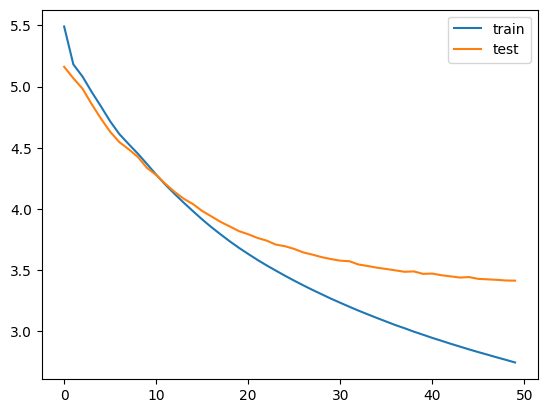

In [ ]:
# loss와 val_loss 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인프런스 모델 구현하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 모델 테스트하기

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : kolkata knight riders tuesday ended rajasthan royals three match winning streak dinesh karthik finished chase six second time jaipur based side ipl kkr kuldeep yadav became eighth left arm spinner take four wicket haul ipl kkr third points table points 
실제 요약 : karthik finishes off chase with as kkr end rr win streak 
1/1 [==============================] - 0s 21ms/step
예측 요약 :  csk defeat srh to win ipl match in ipl match


원문 : iran imposed total ban messaging app telegram saying become safe international terrorist groups including islamic state added company operating messenger repeatedly refused cooperate country authorities last year iran launched criminal probe telegram ceo pavel durov saying app provides services terrorist groups 
실제 요약 : iran bans terror safe haven telegram over security concern 
1/1 [==============================] - 0s 34ms/step
예측 요약 :  iran bans iran over spying on military telegram


원문 : india accounts estimated lakh science engineering bachelor degre

In [134]:
print("Finish")

Finish
